In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import neighbors, tree, ensemble


In [2]:
#To hide FutureWarning & DataConversionWarning from the output
import warnings
from sklearn.exceptions import *
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Data Preparation 

In [3]:
# Training data:
train_x = pd.read_csv("training.csv").drop("price", axis = 1)
train_y = pd.read_csv("training.csv")[["price"]]

# Testing data:
test_x = pd.read_csv("test.csv").drop("price", axis = 1)
test_y = pd.read_csv("test.csv")[["price"]]

In [4]:
# Finding numeric features 
def num_columns(dataframe):
    l = []
    for i in dataframe.columns:
        if dataframe[i].isnull().sum() != 0:
            l.append(i)
    return l

# Finding categorical features :
def cat_columns(dataframe):
    categorical_columns = []
    for col in dataframe.columns:
        if (dataframe[["{}".format(col)]].dtypes == "object").bool() == True:
            categorical_columns.append(col)
    return categorical_columns

# Delete missing instances from label column
def label_na(dataframe):
    global nan_label_index
    nan_label_index = list(dataframe[dataframe.isnull().any(axis = 1)].index)
    dataframe = dataframe.drop(nan_label_index, axis = 0).reset_index(drop = True)
    return dataframe

#Delete label's missing instances from the dataset
class deletelabelna(BaseEstimator, TransformerMixin):
    def __init__(self, nan_label_index):
        self.nan_label_index = nan_label_index
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = pd.DataFrame(X).drop(self.nan_label_index, axis = 0).reset_index(drop = True)
        return X
        
    
# Imputer and scaler pipline for numerical features
num_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy='median')),
                                    ("scaler", StandardScaler())])

# One-hot encoder for categorical features
cat_transformer = Pipeline(steps = [("encoder", OneHotEncoder(sparse = False, dtype = int))])

# lists of column names of numeric and categorical features
num_features = num_columns(train_x)
cat_features = cat_columns(train_x)

# Integrating num and cat transformer
processor = ColumnTransformer(transformers= [('num', num_transformer, num_features),
                                            ('cat', cat_transformer, cat_features)])


In [5]:
# imputing label features
train_y = label_na(train_y)
nan_label_index_train =  nan_label_index  #storing indices to use them in pipeline

test_y = label_na(test_y)
nan_label_index_test =  nan_label_index

#Pipelines of data processing
train_pipe = Pipeline(steps = [('processor', processor),
                             ('deletelablena', deletelabelna(nan_label_index_train))])
test_pipe =  Pipeline(steps = [('processor', processor),
                                 ('deletelablena', deletelabelna(nan_label_index_test))])


# Running data preprocessing pipeline
train_x_e = train_pipe.fit_transform(train_x)
test_x = test_pipe.transform(test_x)

## KNN REGGRESSOR TO PREDICT CAR PRICES 

### a) Training Vs Validation Plot:

In [6]:
#Splitting train_x_e into train and validation sets
train_split_x, val_split_x, train_split_y, val_split_y = train_test_split(train_x_e, train_y, test_size=0.2, random_state=0)

In [7]:
knn_training_errors, knn_validation_error = [], []


for k in range(1, 31):
    knn_reg = neighbors.KNeighborsRegressor(n_neighbors= k) #Build model with different k values
    knn_reg.fit(train_split_x, train_split_y)               # train the model
    train_pred = knn_reg.predict(train_split_x)             #predict on training data
    val_pred = knn_reg.predict(val_split_x)                    #predict on validation data
    knn_training_errors.append(mean_squared_error(train_split_y, train_pred))  #Record MSE of training
    knn_validation_error.append(mean_squared_error(val_split_y, val_pred))     #Record MSE of validation
    k += 1

Text(0, 0.5, 'MSE')

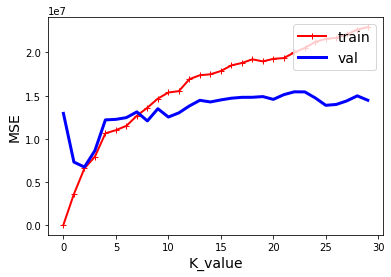

In [8]:
# training vs validation plot
plt.plot(knn_training_errors, "r-+", linewidth=2, label="train")
plt.plot(knn_validation_error, "b-", linewidth=3, label="val")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("K_value", fontsize=14) 
plt.ylabel("MSE", fontsize=14)

### b) Test your model:

In [9]:
# KNN model with best k value based on the above graph (k = 3)
best_knn = neighbors.KNeighborsRegressor(n_neighbors= 3)
best_knn.fit(train_x_e, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [10]:
knn_preds = best_knn.predict(test_x)

In [11]:
knn_mse = mean_squared_error(test_y, knn_preds)
print(knn_mse)

9984318.6625


## DECISION TREE REGRESSOR TO PREDICT CAR PRICES

### c) Grid Search to find best model:

In [12]:
#Decision tree model:
tree_reg = tree.DecisionTreeRegressor() 

#Hyperparameter possible combinations:
tree_hyperparameters = [{"max_depth":[None, 1, 5, 10], "min_samples_split":[0.01, 0.05, 0.1, 0.3], 
                         "max_features":['auto', 'sqrt', 'log2'], "max_leaf_nodes":[10, 50, 100, 250],
                        "random_state":[0]}]

# Building decision tree regression model with grid search
tree_reg_grid = GridSearchCV(tree_reg ,tree_hyperparameters, cv=5, scoring='neg_mean_squared_error')
tree_reg_grid.fit(train_x_e, train_y)

# model's best parameters and MSE
print("model's best parameter: {}\nmodel's best MSE: {}".format(tree_reg_grid.best_params_,
                                                                abs(tree_reg_grid.best_score_)))

model's best parameter: {'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_split': 0.1, 'random_state': 0}
model's best MSE: 10690663.720295105


### d) Test your model:

In [13]:
# Decision tree regression model with best hyperparameter
best_tree = tree.DecisionTreeRegressor(max_depth= None, max_features='auto', max_leaf_nodes=50,
                                       min_samples_split=0.1, random_state= 0)

best_tree.fit(train_x_e, train_y) #fit the model

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=50, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.1, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [14]:
tree_preds = best_tree.predict(test_x)  #predict on test data

In [15]:
# test MSE
tree_mse = mean_squared_error(test_y, tree_preds)
print(tree_mse)

9779323.383824795


## ENSEMBLE BAGGING REGRESSOR TO PREDICT CAR PRICES

### e) Grid Search to find best model:

In [16]:
# Bagging ensemble model:
bag_reg = ensemble.BaggingRegressor()

#Hyperparameter possible combinations:
bag_hyperparameters = [{'base_estimator':[LinearRegression(), neighbors.KNeighborsRegressor(), 
                                              tree.DecisionTreeRegressor(random_state=0)],
                           'n_estimators':[25, 50, 100, 250],
                           'bootstrap_features':[True, False],
                           'random_state':[0]}]


# Building Bagging ensemble model with grid search
bag_grid = GridSearchCV(bag_reg ,bag_hyperparameters, cv=5, scoring='neg_mean_squared_error')
bag_grid.fit(train_x_e, train_y)

# model's best parameters and MSE
print("model's best parameter: {}\nmodel's best MSE: {}".format(bag_grid.best_params_,
                                                                abs(bag_grid.best_score_)))

model's best parameter: {'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best'), 'bootstrap_features': True, 'n_estimators': 25, 'random_state': 0}
model's best MSE: 7755675.6330857705


### f) Test your model:

In [17]:
# Ensemble Bagging regression model with best hyperparameter
best_bag = ensemble.BaggingRegressor(base_estimator=tree.DecisionTreeRegressor(random_state=0),
                                    n_estimators=25, bootstrap_features=True, random_state=0)

best_bag.fit(train_x_e, train_y) #fit the model

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=0,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=True, max_features=1.0,
                 max_samples=1.

In [18]:
bag_preds = best_bag.predict(test_x)  #predict on test data

In [19]:
# test MSE
bag_mse = mean_squared_error(test_y, bag_preds)
print(bag_mse)

5288467.527889098


## RANDOM FOREST REGRESSOR TO PREDICT CAR PRICES

### g) Grid Search to find best model:

In [20]:
# Random forest regression model:
forest_reg = ensemble.RandomForestRegressor()

#Hyperparameter possible combinations:
forest_hyperparameters = [{'n_estimators':[25, 50, 100, 250], 
                          'max_depth':[None, 1, 5, 10], 
                          'random_state':[0]}]
# Building Random forest model with grid search
forest_grid = GridSearchCV(forest_reg ,forest_hyperparameters, cv=5, scoring='neg_mean_squared_error')
forest_grid.fit(train_x_e, train_y)

# model's best parameters and MSE
print("model's best parameter: {}\nmodel's best MSE: {}".format(forest_grid.best_params_,
                                                                abs(forest_grid.best_score_)))

model's best parameter: {'max_depth': 10, 'n_estimators': 250, 'random_state': 0}
model's best MSE: 8924333.957615709


### h) Test your model:

In [21]:
# Random forest regression model with best hyperparameter
best_forest = ensemble.RandomForestRegressor(n_estimators= 250, max_depth=10, random_state= 0)

best_forest.fit(train_x_e, train_y) #fit the model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [22]:
forest_preds =  best_forest.predict(test_x)  #predict on test data

In [23]:
# test MSE
forest_mse = mean_squared_error(test_y, forest_preds)
print(forest_mse)

4725492.046530109


### i) Feature Importances:

In [24]:
# List of features taken from my function in assignment 1
feature_names = ['wheelbase', 
                 'carlength', 
                 'carwidth', 
                 'carheight', 
                 'curbweight', 
                 'enginesize', 
                 'boreratio', 
                 'stroke', 
                 'compressionratio', 
                 'horsepower', 
                 'peakrpm', 
                 'citympg', 
                 'highwaympg',
                 'diesel_fueltype',
                 'gas_fueltype',
                 'std_aspiration',
                 'turbo_aspiration',
                 'four_doornumber',
                 'two_doornumber',
                 'convertible_carbody',
                 'hardtop_carbody',
                 'hatchback_carbody',
                 'sedan_carbody',
                 'wagon_carbody',
                 '4wd_drivewheel',
                 'fwd_drivewheel',
                 'rwd_drivewheel',
                 'front_enginelocation',
                 'rear_enginelocation',
                 'dohc_enginetype',
                 'l_enginetype',
                 'ohc_enginetype',
                 'ohcf_enginetype',
                 'ohcv_enginetype',
                 'rotor_enginetype',
                 'eight_cylindernumber',
                 'five_cylindernumber',
                 'four_cylindernumber',
                 'six_cylindernumber',
                 'three_cylindernumber',
                 'twelve_cylindernumber',
                 'two_cylindernumber',
                 '1bbl_fuelsystem',
                 '2bbl_fuelsystem',
                 '4bbl_fuelsystem',
                 'idi_fuelsystem',
                 'mfi_fuelsystem',
                 'mpfi_fuelsystem',
                 'spdi_fuelsystem']

# Creating dic for feature importance
feature_importance={}
for name, score in zip(feature_names, best_forest.feature_importances_):
    feature_importance[name] = score

# Ordering features based on scores
sorted_feature_importance = sorted(feature_importance, key=feature_importance.get, reverse=True)

#Printing the three most important features
count = 0 
for i in sorted_feature_importance:
    if count < 3:
        print(i + ' = '+ str(feature_importance[i]))
    count +=1

enginesize = 0.6357477722425351
curbweight = 0.10709443408519428
highwaympg = 0.04206867017966015
